In [95]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [96]:
df = pd.read_csv("../data/used_mobile_phone.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4951 entries, 0 to 4950
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   create_date    4951 non-null   object 
 1   price          4951 non-null   float64
 2   text           4951 non-null   object 
 3   phone_model    4951 non-null   object 
 4   factory_price  4951 non-null   int64  
 5   maker          4951 non-null   object 
 6   price_index    4951 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 270.9+ KB
None


,create_date,price,text,phone_model,factory_price,maker,price_index
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05
2,2016-10-25 12 52 00 PM,300000.0,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05
3,2017-03-23 11 14 00 PM,290000.0,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96
4,2016-04-11 7 35 00 PM,280000.0,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59


In [97]:
# create_date로부터 '월'을 의미하는 month 정보를 피처로 추출합니다.
df['month'] = df['create_date'].apply(lambda x: x[:7])

# 월별 거래 횟수를 계산하여 출력합니다.
df['month'].value_counts()

2016-10    2956
2017-03    1311
2016-08     107
2016-09     105
2016-04     102
2016-05      89
2016-06      76
2016-07      74
2016-03      70
2016-02      61
Name: month, dtype: int64

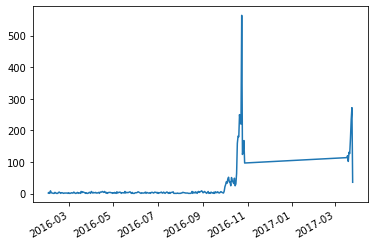

In [98]:
# 일별 거래 횟수를 계산하여 그래프로 출력합니다.
# to_datetime() : 문자를 날짜형식(timestamp)으로 변환
df_day = pd.to_datetime(df['create_date'].apply(lambda x: x[:10])).value_counts()
df_day.plot()
plt.show()

<AxesSubplot:>

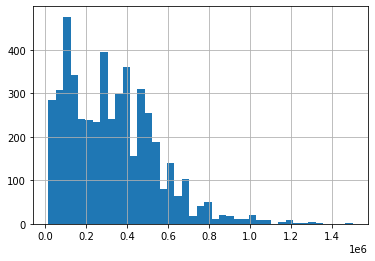

In [99]:
# 가격의 분포를 그래프로 탐색합니다.
df['price'].hist(bins="auto")

<AxesSubplot:>

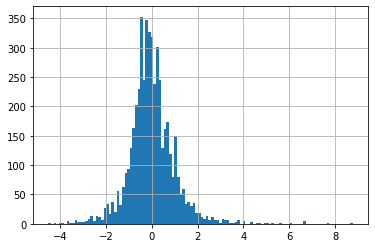

In [100]:
# 휴대폰 기종(phone_model)별 가격의 평균과 표춘편차를 계산합니다.
df_price_model_mean = df.groupby('phone_model')['price'].transform(lambda x: np.mean(x))
df_price_model_std = df.groupby('phone_model')['price'].transform(lambda x: np.std(x))

# 이를 바탕으로 모든 데이터의 z-score(표준화 점수)를 계산합니다.
# z-score는 평균값과 얼마나 거리가 먼지 계산해주는 통계적인 예측값이다.
df_price_model_z_score = (df['price'] - df_price_model_mean) / df_price_model_std
df_price_model_z_score.hist(bins="auto")

<AxesSubplot:xlabel='factory_price', ylabel='price'>

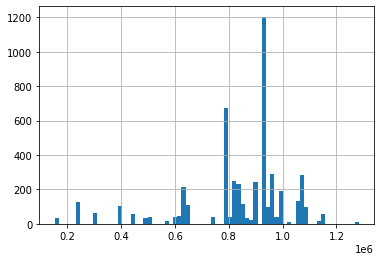

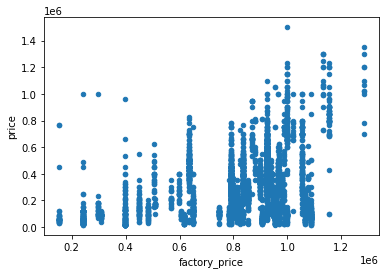

In [101]:
# factory_price 피처의 분포를 탐색합니다.
df['factory_price'].hist(bins="auto")

# factory_price와 price 피처를 산점도 그래프로 출력하여 상관 관계를 살펴봅니다.
df.plot.scatter(x='factory_price', y='price')

count      64.000000
mean       77.359375
std       143.432786
min        10.000000
25%        23.000000
50%        35.000000
75%        90.500000
max      1002.000000
Name: phone_model, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x1f164c42fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x1f164c431c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f164c42cd0>],
 'medians': [<matplotlib.lines.Line2D at 0x1f166f6f370>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f166996a00>],
 'means': []}

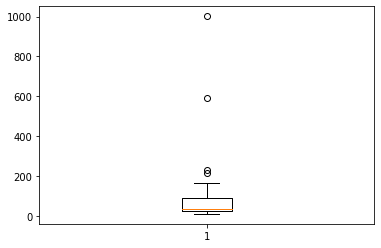

In [102]:
# 기종별 총 거래 데이터 개수를 집계합니다.
model_counts = df['phone_model'].value_counts()
print(model_counts.describe())

# 기종별 총 거래 데이터 개수를 상자 그림으로 살펴봅니다.
plt.boxplot(model_counts)

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [104]:
# 데이터를 학습/테스트용 데이터로 분리합니다.
df = df[['price', 'phone_model', 'factory_price', 'maker', 'price_index', 'month']]
df = pd.get_dummies(df, columns=['phone_model', 'maker', 'month'])
X = df.loc[:, df.columns != 'price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 랜덤 포레스트 모델을 학습합니다.
forest = RandomForestRegressor(n_estimators=1000, criterion='mse')
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

# 학습한 모델을 평가합니다.
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                                      mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),
                                      r2_score(y_test, y_test_pred)))

MSE train: 10621595106.800, test: 13865607489.174
R^2 train: 0.781, test: 0.683


[('factory_price', 0.40611025318824),
 ('maker_apple', 0.29812032787011267),
 ('phone_model_galaxy s3 3g 8gb', 0.022148516510788578),
 ('phone_model_iphone se 64gb', 0.021335121763550485),
 ('price_index', 0.020456986817718233),
 ('phone_model_galaxy s4 32gb', 0.016346987871207128),
 ('month_2017-03', 0.014916344936224016),
 ('maker_samsung', 0.013988397489038618),
 ('phone_model_galaxy s6 32gb', 0.012349543921535786),
 ('month_2016-05', 0.011214947198966197)]

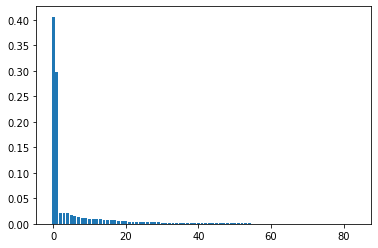

In [105]:
# 학습한 모델의 피처 중요도를 그래프로 살펴봅니다.
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])

# 학습한 모델의 피처 중요도를 출력합니다.
feat_labels = X.columns.tolist()
# zip() 은 동일한 개수로 이루어진 자료형을 묶어 주는 역할을 하는 함수이다.
feature = list(zip(feat_labels, forest.feature_importances_))
# sorted라는 정렬함수는 시퀀스 자료형 뿐만 아니라 순서에 구애받지 않는 자료형에도 적용할 수 있습니다. 정렬된 결과는 list로 반환됩니다.
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

In [106]:
# month 피처 중, 영향력이 높은순으로 정렬하여 출력합니다.
for sorted_feature in sorted(feature, key=lambda tup: tup[1], reverse=True):
    if "month" in sorted_feature[0]:
        print(sorted_feature)

('month_2017-03', 0.014916344936224016)
('month_2016-05', 0.011214947198966197)
('month_2016-09', 0.008144802694789502)
('month_2016-04', 0.007580991436189912)
('month_2016-10', 0.006358812984904656)
('month_2016-06', 0.004458270321860905)
('month_2016-08', 0.003668154801462961)
('month_2016-07', 0.0027786673024145264)
('month_2016-03', 0.002409271551722885)
('month_2016-02', 0.0011385534095722312)


In [107]:
# 데이터를 다시 불러옵니다.
df = pd.read_csv("../data/used_mobile_phone.csv")

In [108]:
from datetime import datetime
import time

In [109]:
# create_date 피처를 수치적으로 계산하기 위해 unixtime으로 변환하는 함수를 정의합니다.
# unixtime : 시간을 정수로 표현한 것이며 값이 클수록 '최근'에 가까워집니다.
def date_to_unixtime(date_str):
    timestamp = time.mktime(datetime.strptime(date_str, '%Y-%m-%d').timetuple())
    return timestamp

# create_date 피처를 '현재와 얼마나 가까운 데이터인지' 판단하기 위한 점수를 생성합니다. 먼저 unixtime으로 데이터를 변환합니다.
df['create_unixtime'] = df['create_date'].apply(lambda x: date_to_unixtime(x[:10]))

# 변환된 unixtime에 min-max 스케일링을 적용합니다.
df['create_time_score'] = (df['create_unixtime'] - df['create_unixtime'].min()) / \
                            (df['create_unixtime'].max() - df['create_unixtime'].min())
df[['create_date', 'create_unixtime', 'create_time_score']].head()

,create_date,create_unixtime,create_time_score
0,2017-03-19 4 35 00 PM,1.489849e+09,0.985612
1,2016-10-26 12 08 00 PM,1.477408e+09,0.640288
2,2016-10-25 12 52 00 PM,1.477321e+09,0.637890
3,2017-03-23 11 14 00 PM,1.490195e+09,0.995204
4,2016-04-11 7 35 00 PM,1.460300e+09,0.165468


In [110]:
# phone_model 피처에서 저장 용량(phone_model_storage) 피처를 추출합니다.
# split함수는 문자열을 공백 혹은 어떠한 기준으로 나눌때 사용하는 함수이다. 
df['phone_model_storage'] = df['phone_model'].apply(lambda x: x.split(" ")[-1])

# phone_model 피처에서 기종 세부명(phone_model_detail) 피처를 추출합니다.
df['phone_model_detail'] = df['phone_model'].apply(lambda x: ' '.join(x.split(" ")[:-1]))
df[['phone_model_storage', 'phone_model_detail']].head()

,phone_model_storage,phone_model_detail
0,64gb,iphone 6
1,32gb,galaxy s6 edge
2,32gb,galaxy s6
3,32gb,lg g5
4,32gb,lg u


{'whiskers': [<matplotlib.lines.Line2D at 0x1f166234af0>,
 'caps': [<matplotlib.lines.Line2D at 0x1f1662342b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f16671a220>,
 'medians': [<matplotlib.lines.Line2D at 0x1f1662630d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1f165e1d700>,
 'means': []}

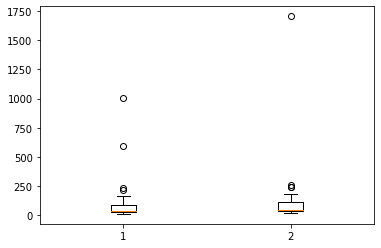

In [111]:
# phone_model 피처의 기종별 거래 데이터 개수를 집계합니다.
model_counts = df['phone_model'].value_counts()

# phone_model_detail 피처의 기종별 거래 데이터 개수를 집계합니다.
model_detail_counts = df['phone_model_detail'].value_counts()
data = [model_counts, model_detail_counts]

# 두 피처 간의 기종별 거래 데이터 개수를 비교합니다.
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)
ax.boxplot(data)

In [112]:
# 기종명 + 용량으로 출고가를 찾기 위한 딕셔너리를 생성합니다.
model_to_factory_price_dict = {}
for index, row in df.iterrows():
    model_concat = (row['phone_model_detail'], row['phone_model_storage'])
    if model_concat in model_to_factory_price_dict:
        pass
    else:
        model_to_factory_price_dict[model_concat] = row['factory_price']
print(str(model_to_factory_price_dict)[:40], "...")

{('iphone 6', '64gb'): 924000, ('galaxy  ...


-1.3966616903783375
1.666982156397844


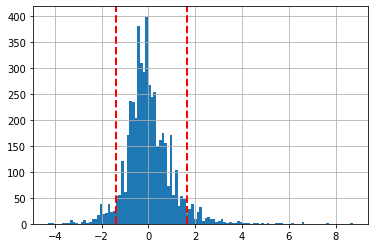

In [113]:
# 거래 가격(price)의; z-score를 계산합니다. 이는 해당 데이터의 가격이 기종의 평균에 비해 어느정도로 높거나 낮은지를 알 수 있게 하는 점수입니다.
# std() : 표준편차
df['price_by_group'] = df.groupby('phone_model_detail')['price'].transform(lambda x: (x - x.mean()) / x.std())

# 거래 가격의 z-score(price_by_group)의 분포를 그래프로 출력합니다.
ax = df['price_by_group'].hist(bins="auto")

# z-score(price_by_group) 기준으로 하위 5%, 상위 5%에 해당하는 점수를 lower_bound, upper_bound라고 지정합니다.
lower_bound = df['price_by_group'].quantile(0.05)
upper_bound = df['price_by_group'].quantile(0.95)

# lower_bound, upper_bound 그래프에 추가합니다.
ax.axvline(x=lower_bound, color='r', linestyle='dashed', linewidth=2)
ax.axvline(x=upper_bound, color='r', linestyle='dashed', linewidth=2)

# lower_bound, upper_bound를 출력합니다.
print(lower_bound)
print(upper_bound)

In [114]:
# lower_bound보다 낮으면 0, upper_bound보다 높으면 2, 그 중간이면 1로 가격의 상태를 분류하는 함수를 정의합니다.
def get_price_level(price, lower, upper):
    if price <= lower:
        return "0"
    elif price >= upper:
        return "2"
    else:
        return "1"

# lower_bound보다 낮으면 0, upper_bound보다 높으면 2, 그 중간이면 1로 가격의 상태를 분류합니다.
df['price_lower'] = df.groupby('phone_model_detail')['price'].transform(lambda x: x.quantile(0.05))
df['price_upper'] = df.groupby('phone_model_detail')['price'].transform(lambda x: x.quantile(0.95))
df['price_level'] = df.apply(lambda row: get_price_level(row['price'], row['price_lower'], 
                                                         row['price_upper']), axis=1)
df[['price', 'price_lower', 'price_upper', 'price_level', 'text']].head()

,price,price_lower,price_upper,price_level,text
0,550000.0,180000.0,680000.0,1,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...
1,380000.0,180000.0,414000.0,1,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...
2,300000.0,150000.0,349000.0,1,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...
3,290000.0,100000.0,500000.0,1,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...
4,280000.0,18000.0,400000.0,1,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...


In [115]:
import pickle
import re

In [116]:
# 중고나라 불용어 사전을 불러옵니다.
with open('../data/used_mobile_phone_stopwords.pkl', 'rb') as f:
    stopwords = pickle.load(f)
# 불용어 사전에 등록된 단어 10개를 출력합니다.
print(stopwords[:10])

['거래', '입니', '판매', '아이폰', '갤럭시', '골드', '팝', '만원', '폰', '시']


In [117]:
from konlpy.tag import Okt

In [118]:
# ‘+’를 제외한 특수문자를 제거하고, 숫자형태의 문자를 제거합니다.
def text_cleaning(text):
    text = ''.join(c for c in text if c.isalnum() or c in '+, ')
    text = ''.join([i for i in text if not i.isdigit()])
    return text

# 불용어에 등장하지 않는 형태소만을 추출하여 반환하는 함수입니다.
def get_pos(x):
    tagger = Okt()
    poses = tagger.pos(x)
    return [pos[0] for pos in poses if pos[0] not in stopwords]

# 위 함수들을 적용한 형태소 추출을 테스트합니다.
df['text'] = df['text'].apply(lambda x: text_cleaning(x))
result = get_pos(df['text'][0])
print(result)

['+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '리퍼', '기간', '만료', '되어서', '징', '하게', '되었습니다', '상태', '초', 'a', '급', '스', '없습니다', '+', '애플', '라이트', '팝니다', '+', '애플', '라이트', '팝니다', '리퍼', '기간', '만료', '되어서', '징', '하게', '되었습니다', '상태', '초', 'a', '급', '스', '없습니다', '징', '애플', '라이트', '홈', '버튼', '링', '카메라', '링', '볼륨', '버튼', '슬립', '버튼', '검금', '심플', '튀지', '않게', '이쁘게', '했구요', '유심', '꽂고', '바로', '사용', '하시면', '됩니다', '사람', '이냐', '자주', '물어보고', '실제', '더욱', '이쁩니다', '밤', '영롱하게', '맥북', '뒷', '사과', '로고', '비춰지고', '요전', '넘어가기', '위해', '합니다', '가능합니다', '박스', '어머니', '버리시고', '이어폰', '충전기', '정품', '드립니다', '직거래', '우선', '순', '위로', '정', '싶으시면', '선', '입금', '택배', '발송', '해드리겠습니다', '믿으시면', '직거래', '하시길', '추천', '해요', '안전', '합니다', '서울시', '강남구', '역삼동', '차병원', '사거리', '근처', '가격']


In [119]:
from collections import Counter

In [120]:
# get_pos() 함수를 모든 텍스트 데이터에 적용하여 형태소 말뭉치를 추출합니다.
corpus = sum(df['text'].apply(lambda x: get_pos(x)).tolist(), [])

# 추출된 형태소 말뭉치에서 가장 많이 등장한 형태소 2500개를 추출합니다.
counter = Counter(corpus)
# most_common(2500) : 데이터의 개수가 많은 순으로 정렬된 배열을 리턴
common_wrods = [key for key, _ in counter.most_common(2500)]
common_wrods

['입니다',
 '직거래',
 's',
 '합니다',
 '택배',
 '사용',
 '급',
 '상태',
 '팝니다',
 '가능합니다',
 '정상',
 '사진',
 '가격',
 '+',
 '케이스',
 'a',
 '주세요',
 '해지',
 '삭제',
 '제품',
 '있습니다',
 '박스',
 '가능',
 '직접',
 '액정',
 '배터리',
 '성품',
 '필름',
 '리퍼',
 '충전기',
 '없습니다',
 '풀',
 '개통',
 '유심',
 '즈',
 '안전',
 '스',
 '하기',
 '신청',
 '드립니다',
 '통신사',
 '구입',
 '약정',
 '이어폰',
 '공기',
 '새',
 '기변',
 '포함',
 '모델',
 '선택',
 '됩니다',
 '확인',
 '기간',
 '기스',
 '그레이',
 '찍힘',
 '방법',
 '바로',
 '할인',
 '제',
 '시기',
 '스페이스',
 '희망',
 '번호',
 '중고나라',
 '본체',
 '같이',
 '생활',
 '잘',
 '무',
 '퀵',
 '글',
 '된',
 '않을',
 '공식',
 '앱',
 '확정',
 '기능',
 '다운',
 '양',
 '호환',
 '케이블',
 '받기',
 '미',
 '이메일',
 '작성',
 '부분',
 '금지',
 '될수',
 '식아이디',
 '허위',
 '임의',
 '통보',
 '채우지',
 '핸드폰',
 '편한',
 '전혀',
 '충전',
 '내용',
 '연락처',
 '단말기',
 '부산',
 '대구',
 '미사',
 '정품',
 '중고',
 '문제',
 '없이',
 '이상',
 '보호',
 '방문',
 '없는',
 '외관',
 '외',
 '인천',
 '깨끗합니다',
 'x',
 '초기',
 '하나',
 '참고',
 '이구',
 '요금',
 '개월',
 '이나',
 '사이트',
 '팔아요',
 '하시면',
 '했습니다',
 '동',
 '카페',
 '보내',
 '카톡',
 '블로그',
 '링크',
 '싸이',
 '강퇴',
 '삼성',
 '거치',
 '있는',
 '호선'

In [121]:
# TF-IDF 벡터 생성
df['price_level'].value_counts()

1    4296
0     334
2     321
Name: price_level, dtype: int64

In [122]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [123]:
# 반출 형태소를 제외한 모든 형태소를 제거하는 함수를 정의합니다.
def get_common_pos(x):
        tagger = Okt()
        poses = tagger.pos(x)
        return [pos[0] for pos in poses if pos[0] in common_wrods]
    
# 1:3:1 비율로 랜덤 샘플링을 수행합니다.
negative_random = df[df['price_level']=='0'].sample(321, random_state=30)
neutral_random = df[df['price_level']=='1'].sample(321*3, random_state=30)
positive_random = df[df['price_level']=='2'].sample(321, random_state=30)

# 샘플링 완료된 데이터셋을 정의합니다.
df_sample = negative_random.append(neutral_random).append(positive_random)

# TF-IDF를 수행하여 피쳐를 반환합니다.
# TF-IDF(Term Frequency - Inverse Document Frequency)는 정보 검색과 텍스트 마이닝에서 이용하는 가중치로, 
# 여러 문서로 이루어진 문서군이 있을 때 어떤 단어가 특정 문서 내에서 얼마나 중요한 것인지를 나타내는 통계적 수치이다
index_vectorizer = CountVectorizer(tokenizer= lambda x: get_common_pos(x))
# fit_transform() 메소드는 말 그대로 fit()한 다음에 transform() 하는 것입니다
X = index_vectorizer.fit_transform(df_sample['text'].tolist())
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

# 감성 분류를 위한 학습 데이터셋을 정의합니다.
y = df_sample['price_level']
# train_test_split 함수는 전체 데이터셋 배열을 받아서 랜덤하게 test/train 데이터 셋으로 분리해주는 함수이다.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=30)
# NumPy 배열에서 배열의 형태를 알아보는 shape()
print(x_train.shape)
print(x_test.shape)

(1284, 2476)
(321, 2476)


In [124]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [125]:
# 비선형 SVM 분류 모델을 학습하고 평가합니다.
# 서포트 벡터 머신(이하 SVM)은 결정 경계(Decision Boundary), 즉 분류를 위한 기준 선을 정의하는 모델이다.
svm = SVC(kernel='rbf', C=10.0, random_state=0, gamma=0.10)
svm.fit(x_train, y_train)
y_pred_ksvc = svm.predict(x_test)
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred_ksvc))

# Confusion Matrix를 출력합니다.
# Confusion Matrix(혼동행렬) 예측값이 실제 관측값을 얼마나 정확히 예측했는지 보여주는 행렬
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred_ksvc)
print(confmat)

Accuracy: 0.77
[[ 30  28   4]
 [ 10 181  10]
 [  2  21  35]]


MSE train: 4769851953.497, test: 11007159124.665
R^2 train: 0.902, test: 0.748


[('maker_apple', 0.2539240725565022),
 ('factory_price', 0.25257781837222315),
 ('create_time_score', 0.11657387866616874),
 ('phone_model_storage_16gb', 0.060387845966089516),
 ('product_status_2', 0.047121848517873766),
 ('phone_model_detail_galaxy s7 edge', 0.02841177860101892),
 ('phone_model_storage_64gb', 0.026441577019253645),
 ('phone_model_detail_galaxy note5', 0.02450152516737515),
 ('phone_model_detail_galaxy s7', 0.02235048679273618),
 ('product_status_0', 0.021835410207178045)]

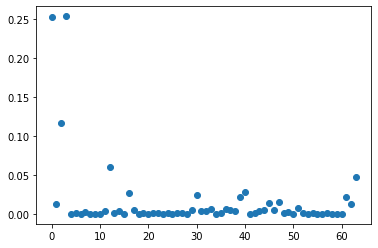

In [126]:
# text 피처로부터 '상품 상태 피처(product_status)'를 생성합니다.
# transform() 메서드는 입력된 객체와 동일하게 인덱스된 객체를 반환한다.
X = index_vectorizer.transform(df['text'].tolist())
X = tfidf_vectorizer.transform(X)
df['product_status'] = pd.Series(svm.predict(X))

# 랜덤 포레스트 모델 학습을 위한 데이터를 준비합니다.
df = df[['price', 'factory_price', 'maker', 'price_index', 'create_time_score', 'phone_model_storage',
                'phone_model_detail', 'product_status']]
df = pd.get_dummies(df, columns=['maker', 'phone_model_storage', 'phone_model_detail', 'product_status'])

# 학습/테스트 데이터를 분리합니다.
X = df.loc[:, df.columns != 'price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 랜덤 포레스트 모델을 학습하고 평가합니다.
forest = RandomForestRegressor(n_estimators=1000, criterion='mse')
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
# mean_squared_error : RMSE를 구하는 함수
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                                      mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),
                                      r2_score(y_test, y_test_pred)))

# 피처 중요도 plot을 출력합니다.
importances = forest.feature_importances_
plt.plot(importances, "o")

# 피처 중요도를 print로 출력합니다.
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, forest.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

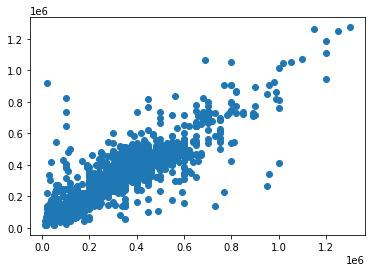

In [127]:
# 테스트 데이터의 y값과 예측된 y값을 산점도 그래프를 활용하여 상관 관계를 살펴봅시다.
plt.scatter(y_test.values, y_test_pred)

In [128]:
from sklearn.model_selection import RandomizedSearchCV

In [129]:
# Randomized Search 로 찾아낼 파라미터 후보군을 각각 리스트로 선정합니다.
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
bootstrap = [True, False]

# RandomizedSearchCV 오브젝트를 생성하여 모델을 정의합니다.
# n_estimators : 생성할 tree의 개수와
# max_features : 최대 선택할 특성의 수입니다.
# max_depth : 트리의 최대 깊이, 깊이가 깊어지면 과적합될 수 있으므로 적절히 제어 필요
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}
forest = RandomForestRegressor()
# RandomizedSearchCV 반복적인 실행으로 최적의 파라미터를 찾기 위한 방법
optimal_forest = RandomizedSearchCV(estimator = forest, 
                                    param_distributions = random_grid, 
                                    n_iter = 100, 
                                    cv = 3, 
                                    verbose=2,
                                    random_state=42, 
                                    n_jobs = -1)

# RandomizedSearchCV 모델을 학습합니다.
X = df.loc[:, df.columns != 'price']
y = df['price']
optimal_forest.fit(X,y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [130]:
# 앞서 선정한 파라미터 후보군 중에서 가장 좋은 결과를 보인 파리미터의 조합을 출력합니다.
print(optimal_forest.best_params_)

{'n_estimators': 2000, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': False}


MSE train: 8808369256.099, test: 7645658185.602
R^2 train: 0.818, test: 0.825


[('factory_price', 0.29649234203896563),
 ('maker_apple', 0.27561464058016766),
 ('phone_model_storage_16gb', 0.07214573778761102),
 ('create_time_score', 0.06578494750560891),
 ('product_status_2', 0.06261880977705984),
 ('phone_model_detail_galaxy s7 edge', 0.027077101617630186),
 ('phone_model_detail_iphone 6', 0.025043983708273966),
 ('product_status_0', 0.02457729485726569),
 ('phone_model_detail_galaxy s4', 0.02053025348047875),
 ('product_status_1', 0.013691014385808652)]

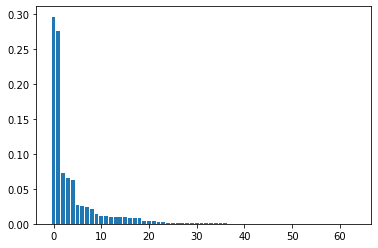

In [131]:
# 최적의 파라미터를 적용한 모델로 중고 휴대폰의 가격을 예측하고 평가합니다. 
y_train_pred = optimal_forest.predict(X_train)
y_test_pred = optimal_forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

# 가격 예측 모델의 피처 중요도 plot을 출력합니다.
importances = optimal_forest.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
plt.bar(range(X.shape[1]), importances[indices])

# 가격 예측 모델의 피처 중요도를 출력합니다.
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, optimal_forest.best_estimator_.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

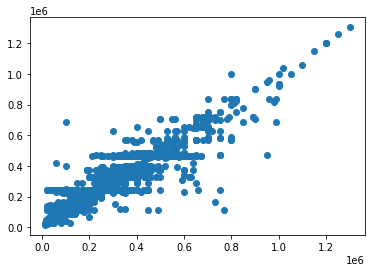

In [132]:
# 테스트 데이터의 y값과 예측된 y값을 산점도 그래프를 활용하여 상관 관계를 살펴봅시다.
plt.scatter(y_test.values, y_test_pred)

In [133]:
import joblib

In [134]:
# 프로그램에서 입력값에 대한 피처를 찾기 위한 딕셔너리를 생성합니다.
col_to_index_dict = {}
# enumerate는 "열거하다"라는 뜻이다. 
# 이 함수는 순서가 있는 자료형(리스트, 튜플, 문자열)을 입력으로 받아 인덱스 값을 포함하는 enumerate 객체를 돌려준다.
for idx, col in enumerate(df.columns[1:]):
    col_to_index_dict[col] = idx
    
print(str(col_to_index_dict)[:40], "...")

{'factory_price': 0, 'price_index': 1, ' ...


In [135]:
# 모델 예측을 위한 중간 오브젝트들을 각각 파일로 저장합니다.
with open('../data/used_mobile_pickles/model_to_factory_price_dict.pickle', 'wb') as f:
    pickle.dump(model_to_factory_price_dict, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/col_to_index_dict.pickle', 'wb') as f:
    pickle.dump(col_to_index_dict, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/common_words.pickle', 'wb') as f:
    pickle.dump(common_wrods, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/init_vectorizer_vocabulary.pickle', 'wb') as f:
    pickle.dump(index_vectorizer.vocabulary_, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/tfidf_vectorizer.pickle', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f, pickle.HIGHEST_PROTOCOL)
    
with open('../data/used_mobile_pickles/svm_classifier.pickle', 'wb') as f:
    pickle.dump(svm, f, pickle.HIGHEST_PROTOCOL)

joblib.dump(optimal_forest.best_estimator_, '../data/used_mobile_pickles/rf_regressor.pickle', compress = 1)

['../data/used_mobile_pickles/rf_regressor.pickle']

In [136]:
# 예측에 필요한 파일 로드
with open('../data/used_mobile_pickles/model_to_factory_price_dict.pickle', 'rb') as f:
    model_to_factory_price_dict = pickle.load(f)
    
with open('../data/used_mobile_pickles/col_to_index_dict.pickle', 'rb') as f:
    col_to_index_dict = pickle.load(f)
    
with open('../data/used_mobile_pickles/common_words.pickle', 'rb') as f:
    common_words = pickle.load(f)

with open('../data/used_mobile_pickles/init_vectorizer_vocabulary.pickle', 'rb') as f:
    init_vectorizer_vocabulary = pickle.load(f)
    
with open('../data/used_mobile_pickles/tfidf_vectorizer.pickle', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)
    
with open('../data/used_mobile_pickles/svm_classifier.pickle', 'rb') as f:
    svm_classifier = pickle.load(f)

rf_regressor = joblib.load('../data/used_mobile_pickles/rf_regressor.pickle')

In [137]:
import numpy as np

from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [138]:
class Almhago():
    def __init__(self, model_to_factory_price_dict, col_to_index_dict, 
                 common_words, init_vectorizer_vocabulary, tfidf_vectorizer, 
                 prd_status_classifier, price_regressor):
        self._model_to_factory_price_dict = model_to_factory_price_dict
        self._col_to_index_dict = col_to_index_dict
        self._common_words = common_words
        self._init_vectorizer_vocabulary = init_vectorizer_vocabulary
        self._index_vectorizer = self._init_index_vectorizer()
        self._tfidf_vectorizer = tfidf_vectorizer
        self._prd_status_classifier = prd_status_classifier
        self._price_regressor = price_regressor
        
    def _get_common_pos(self, x):
        tagger = Okt()
        poses = tagger.pos(x)
        return [pos[0] for pos in poses if pos[0] in self._common_words]
    
    def _text_cleaning(self, text):
        text = ''.join(c for c in text if c.isalnum() or c in '+, ')
        text = ''.join([i for i in text if not i.isdigit()])
        return text
        
    def _init_index_vectorizer(self):
        word_index_vectorizer = CountVectorizer(tokenizer = lambda x: self._get_common_pos(x))
        word_index_vectorizer.vocabulary_ = self._init_vectorizer_vocabulary
        return word_index_vectorizer
    
    def _get_ftr_price(self, model_name, storage):
        return self._model_to_factory_price_dict[(model_name, storage)]
    
    def _get_prd_status(self, text):
        X = self._index_vectorizer.transform([self._text_cleaning(program_test_dict['text'])])
        X = self._tfidf_vectorizer.transform(X)
        return self._prd_status_classifier.predict(X)[0]
    
    def _print_almhago(self, model, price, prd_status):
        status = ""
        if prd_status == "0":
            status = "불량한"
        elif prd_status == "1":
            status = "양호한"
        else:
            status = "좋은"
        print("선택하신", model, "모델은", status, "상태입니다. Almhago 예상 가격은", str(int(price[0])), "원 입니다.")
    
    def predict(self, input_dict):
        feature = np.zeros(64)
        feature[self._col_to_index_dict['factory_price']] = self._get_ftr_price(input_dict['phone_model_detail'],
                                                                                input_dict['phone_model_storage'])
        feature[self._col_to_index_dict['price_index']] = input_dict['price_index']
        feature[self._col_to_index_dict['create_time_score']] = input_dict['create_time_score']
        feature[self._col_to_index_dict["_".join(["maker", input_dict['maker']])]] = 1
        feature[self._col_to_index_dict["_".join(["phone_model_detail", input_dict['phone_model_detail']])]] = 1
        feature[self._col_to_index_dict["_".join(["phone_model_storage", input_dict['phone_model_storage']])]] = 1
        feature[self._col_to_index_dict["_".join(["product_status", self._get_prd_status(input_dict['text'])])]] = 1
        
        # predict result
        predicted_price = self._price_regressor.predict([feature])
        self._print_almhago(input_dict['phone_model_detail'], 
                            predicted_price, 
                            self._get_prd_status(input_dict['text']))

In [139]:
# 데이터의 가장 최근 시점인 2017년 4월을 기준으로 하기 위한 두 개(price_index, create_time_score)의 피처를 정의합니다.
recent_price_index = 95.96
recent_create_time_score = 1.0

# 판매 가격을 예측하고자 하는 메이커, 기종, 용량을 입력하고, 상품의 상태를 나타내는 게시글을 입력합니다.
program_test_dict = {"maker": "apple",
                     "phone_model_detail": "iphone 6",
                     "phone_model_storage": "16gb",
                     "text": '아이폰6 스페이스그레이 16기가 10만원에 팔아요~ 직접거래 \
                     메인보드 세척 완료 한 침수 폰 입니다폰 안켜지는 상테이구요 고쳐서 쓰실분 가져가세요10만원에 팔아요 \
                     리퍼한지 얼마안되서 기스 이런거 하나도 없습니당~서울 강남 근처 직거래 가능하며택배거래도 가능해요',
                     "price_index": recent_price_index,
                     "create_time_score": recent_create_time_score}

# 정의한 피처를 파라미터로 하여 almhago 오브젝트를 생성합니다.
almhago = Almhago(model_to_factory_price_dict, col_to_index_dict, 
                  common_wrods, init_vectorizer_vocabulary, tfidf_vectorizer, 
                  svm_classifier, rf_regressor)

# 입력한 데이터로 판매 가격을 예측합니다.
almhago.predict(program_test_dict)

선택하신 iphone 6 모델은 불량한 상태입니다. Almhago 예상 가격은 152307 원 입니다.
